# Desafío Spike : 'Predicción de caudales extremos'
### Gonzalo Riquelme

1. Baja el archivo caudal_extra.csv. Puedes bajarlo de BigQuery (vean el código al final de este documento), o bien, desde Github (https://github.com/SpikeLab-CL/desafio_spike_cuencas).

In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
os.chdir('C:/Users/iriqu/desktop/Gonzalo/programacion/desafiospike')

In [3]:
import pandas as pd
data = pd.read_csv('caudal_extra.csv',header=0, parse_dates=['fecha'], index_col=0,infer_datetime_format=True)
inicial=len(data)

C:\Users\iriqu\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Se pasa la columna fecha a formato datetime y se deja como index la columna 0 que enumera los datos.

2. Analiza el dataset caudal_extra.csv. ¿Qué puedes decir de los datos, distribuciones, missing, u otros? ¿Hay algo que te llame la atención? ¿Por qué hay tantos valores missing? Pensar en la manera en que se elaboró el dataset, descrito más arriba. (Entregable: texto/imágenes)

In [4]:
data.sort_values(['codigo_estacion', 'fecha'], inplace=True)
data=data[data.fecha>='1990']
print(round((len(data)/inicial)*100,2), '% Se toma de los datos')

63.23 % Se toma de los datos


In [5]:
#Visualizamos los datos para tener una idea general
data.head()

,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio
99066,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1990-01-01,0.033,1020003,Rio Lauca En Estancia El Lago,0.100000,12.1
98113,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1990-01-02,0.033,1020003,Rio Lauca En Estancia El Lago,0.000000,14.6
90958,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1990-01-03,0.034,1020003,Rio Lauca En Estancia El Lago,0.000000,14.3
93909,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1990-01-04,0.032,1020003,Rio Lauca En Estancia El Lago,1.933333,17.6
90959,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1990-01-05,0.035,1020003,Rio Lauca En Estancia El Lago,7.150000,14.6


In [6]:
# Se identifican valores únicos para algunas variables, de esta forma se pueden ver cantidades involucradas (cuencas, estaciones,etc)

print('Número de años',len(data.fecha.dt.year.unique()))
print('Número de sub-cuencas',len(data.nombre_sub_cuenca.unique()))
print('Número de cuencas',len(data.codigo_cuenca.unique()))
print('Número de nombres de cuencas',len(data.gauge_name.unique()))
print('Número de id de cuencas',len(data.gauge_id.unique()))
print('Número de nombres',len(data.nombre.unique()))
print('Número de estaciones de medicion de caudal',len(data.codigo_estacion.unique()))
print('Número de fuentes de informacion', len(data.fuente.unique()))
print('Número de instituciones de informacion', len(data.institucion.unique()))


Número de años 29
Número de sub-cuencas 76
Número de cuencas 29
Número de nombres de cuencas 123
Número de id de cuencas 123
Número de nombres 123
Número de estaciones de medicion de caudal 123
Número de fuentes de informacion 1
Número de instituciones de informacion 1


Se puede notar que 'gauge_id','gauge_name','nombre' y 'codigo_estacion', identifican de la misma forma. Cada id de una cuenca está asociada a una estación de medición. Por lo tanto, se eliminan gauge_name y nombre que, además, son lo mismo. Tambien se eliminan 'Unnamed: 0', 'fuente', 'intstitucion','latitud'y 'longitud', no se utilizan por el momento.

In [7]:
data=data.drop(columns=['fuente','institucion','latitud','longitud','gauge_name','nombre'])

In [8]:
# A continuación se revisan missing values

print('Tamaño de la muestra:',len(data))
null=data.isnull().sum()
percent=null*100/len(data)
missingtable=pd.concat([null,percent],axis=1)
missingtable=missingtable.rename(columns={0:'# de observaciones',1:'%',2:'dtype'})
missingtable=missingtable[missingtable['# de observaciones']>0]
print('Tabla missing values')
missingtable.sort_values(by='%',ascending=False)

Tamaño de la muestra: 892222
Tabla missing values


,# de observaciones,%
temp_max_promedio,33662,3.772828
precip_promedio,7799,0.874110


En las instrucciones del desafío se explica que los datos de **caudal** provienen de una fuente distinta a los datos de **temperatura** y **precipitación**. De esta manera, existen cuencas (con el dato **caudal**) que no presentan los datos de **temperatura y precipitación**. 

In [9]:
data.dtypes

codigo_estacion                    int64
altura                             int64
codigo_cuenca                      int64
nombre_sub_cuenca                 object
cantidad_observaciones             int64
fecha                     datetime64[ns]
caudal                           float64
gauge_id                           int64
precip_promedio                  float64
temp_max_promedio                float64
dtype: object

In [10]:
data_cols = {'caudal': {'unidad':'m3/s', 'nombre': 'caudal'},
             'precip_promedio': {'unidad':'mm', 'nombre': 'precipitaciones'},
             'temp_max_promedio': {'unidad':'C', 'nombre': 'temperatura'}}
               

In [11]:
data[list(data_cols.keys())].describe()

,caudal,precip_promedio,temp_max_promedio
count,892222.000000,884423.000000,858560.000000
mean,116.918427,1.990629,18.576221
std,278.842782,7.303622,7.318013
min,0.000000,0.000000,-19.049999
25%,1.270000,0.000000,13.100000
50%,12.900000,0.000000,18.350000
75%,93.500000,0.050000,24.360001
max,15805.000000,258.600006,41.500000


In [12]:
data[list(data_cols.keys())].isnull().sum()/len(data)

caudal               0.000000
precip_promedio      0.008741
temp_max_promedio    0.037728
dtype: float64

Por la forma en que se unieron los datos de caudal de las cuencas con las estaciones meteorológicas, pueden haber cuencas que no tengan ninguna estación de temperatura o precipitación asociada. Una forma de mejorar esto podría ser interpolando la temperatura o precipitación de estaciones cercanas.

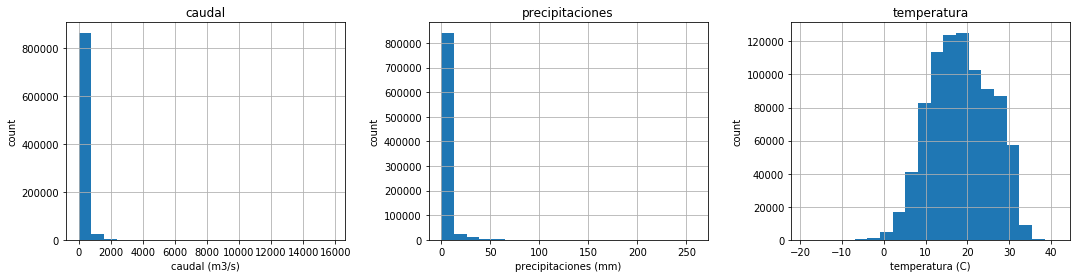

In [13]:
fig, axes = plt.subplots(1,3,figsize=(18,4))
plt.subplots_adjust(wspace=.3)

for i, col in enumerate(data_cols.keys()):
    
    data[col].hist(ax=axes[i], bins=20)
    
    axes[i].set_title(data_cols[col]['nombre'])
    axes[i].set_ylabel('count')
    axes[i].set_xlabel(('{} ({})'.format(data_cols[col]['nombre'], data_cols[col]['unidad'])))

plt.show()

In [14]:
data.groupby('codigo_estacion')['fecha'].max().sort_values().head(15)

codigo_estacion
3826001    1997-08-17
8106001    1998-11-30
4714001    2003-09-26
2104003    2006-03-28
5734001    2006-10-11
2110002    2009-06-23
2112005    2012-01-25
3450001    2012-11-29
2105005    2013-08-27
3806001    2015-02-24
3434003    2015-03-24
2112006    2015-12-17
11147001   2016-03-25
2105007    2016-04-27
8304001    2016-05-31
Name: fecha, dtype: datetime64[ns]

In [15]:
(data.groupby('codigo_estacion')['fecha'].max() > '2018').mean()

0.4959349593495935

~50% llega hasta 2018, es decir, el otro 50% no tiene datos luego del 2018.

3. Plots de precipitación, temperatura y caudal

a. Escribir una función que tome como input una estación y haga plot de los datos para
una columna. Debiese tener estos argumentos:


In [16]:
import matplotlib.pyplot as plt
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):
    dataplot = data.loc[data.codigo_estacion==codigo_estacion,['fecha',columna]]
    dataplot.set_index('fecha', inplace=True)
    dataplot = dataplot[fecha_min:fecha_max]
    columna_ordenada = dataplot[columna].sort_index()
    nombre_cuenca = data.loc[data.codigo_estacion==codigo_estacion,'nombre_sub_cuenca'].unique()[0]
    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(columna_ordenada)
    ax.set_title('{} en {}'.format(data_cols[columna]['nombre'].title(), nombre_cuenca))
    ax.set_ylabel('{} ({})'.format(data_cols[columna]['nombre'], data_cols[columna]['unidad']))
    fig.autofmt_xdate()

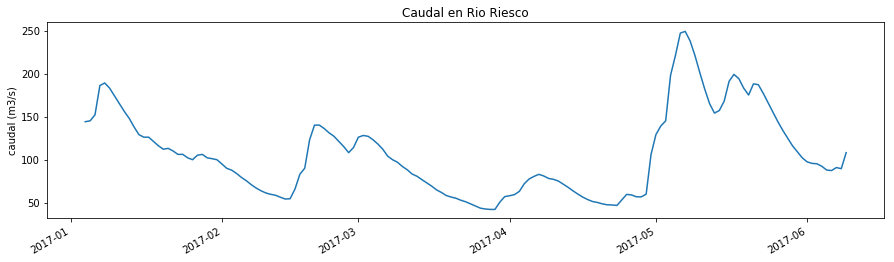

In [17]:
time_plot_una_estacion(11335002,'caudal',fecha_min='2017-01-04',fecha_max='2017-06-09')

b. Ahora escribir una función que haga plots de varias columnas, para poder visualizar caudal, precipitación y temperatura al mismo tiempo. Como las series están en diferentes escalas, sugerimos normalizarlas antes de hacer el plot (por ejemplo, dividiendo por la primera observación de cada seria)


In [18]:
def time_plot_estacion_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):
    dataplot = data.loc[data.codigo_estacion==codigo_estacion,['fecha']+columnas]
    dataplot.set_index('fecha', inplace=True)
    dataplot = dataplot[fecha_min:fecha_max]
    fig, ax = plt.subplots(figsize=(15,4))
    nombre_cuenca = data.loc[data.codigo_estacion==codigo_estacion,'nombre_sub_cuenca'].unique()[0]
    for item in columnas:
        columna_ordenada = dataplot[item].sort_index()
        columna_ordenada = (columna_ordenada-columna_ordenada.mean())/columna_ordenada.std()
        columna_ordenada.plot(ax=ax,label='{} ({})'.format(data_cols[item]['nombre'], data_cols[item]['unidad']))
        fig.autofmt_xdate()
    ax.legend()
    ax.set_title('{}'.format(nombre_cuenca))
    ax.set_ylabel('unidad normalizada')

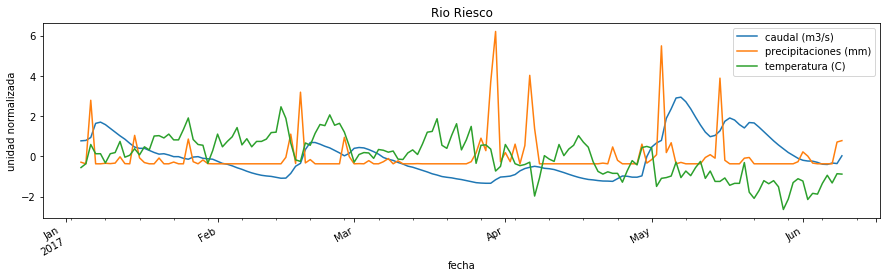

In [19]:
time_plot_estacion_varias_columnas(11335002,['caudal','precip_promedio','temp_max_promedio'],fecha_min='2017-01-04',fecha_max='2017-06-09')

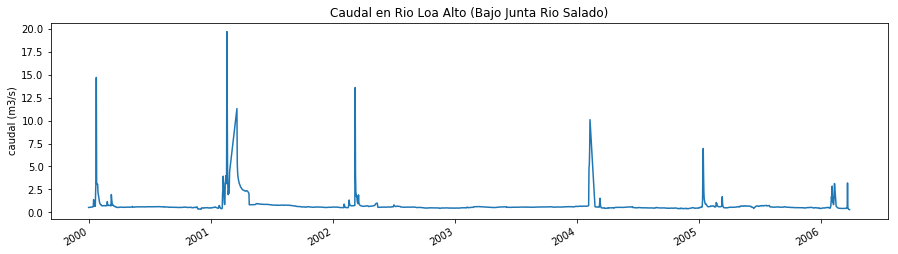

In [20]:
time_plot_una_estacion(2104003, 'caudal', '2000', '2010')

4. Crea tres variables llamadas.
     * caudal_extremo
     * temp_extremo
     * precip_extremo

Vale 1 si está sobre el percentil 95 de su respectiva estación del año. 
Vale 0 en caso contrario.

* Verano ->  12-21 al 03-20 (21 de diciembre al 20 de marzo)
* Otoño ->  03-20 al 06-21 (20 de marzo al 21 de junio)
* Invierno -> 06-21 al 09-21 (21 de junio al 21 de septiembre)
* Primavera -> 09-21 al 12-21 (21 de septiembre al 21 de diciembre)

A continuación se crea la variable 'quarter' que divide en cuartos los meses del año, distinto a las estaciones. Se utiliza un arreglo matemático que encontré genial, copiado de otro notebook.

In [21]:
data['quarter']=(data.fecha.dt.month-1)//3+1

El código siguiente también es copiado. Crea la variable percentil para cada columna de interés, se agrupa por estación metorológica y por quarter. Luego se reemplaza cada valor por su percentil correspondiente. (Los percentiles se obtienen luego de ordenar los datos de menor a mayor (sin repeticiones) y se divide su ranking bajo el total de valores únicos. Muestra su posición relativa al resto de valores únicos. El código es impresionantemente sencillo.

In [22]:
data[[x + '_pct' for x in data_cols.keys()]] = data.groupby(['codigo_estacion', 'quarter'])[list(data_cols.keys())].transform(lambda x: x.rank(pct=True))

In [23]:
for col in data_cols.keys():
    data[col + '_extremo'] = (data[col + '_pct'] > .95).astype(int)
    
data[[x + '_extremo' for x in data_cols.keys()]].mean()

caudal_extremo               0.050267
precip_promedio_extremo      0.045008
temp_max_promedio_extremo    0.048234
dtype: float64

* Responder preguntas ¿Les parece razonable esta medida para capturar algo “extremo”? ¿Usarían otra? ¿Cuál? (no codifiquen)
* Me parece una buena idea. Otra alternativa, puede ser definir valores de corte para cada estación del año, sin considerar estaciones de medicion. Para definir los valores de corte se podría tomar el promedio de los percentil 95 de cada estación dada una ventana de tiempo. Por ejemplo, agrupar cada 5 años y sacar el promedio de los percentiles 95 de invierno. Luego ese sería el corte. La idea general consiste en definir valores extremos dada una ventana de tiempo, es como una extensión de la propuesta de Spike.
* Una vez creadas las variables se nos pide analizar la variable caudal extremo y ver con cuencas


5. Analicen la variable caudal_extremo. Los comportamientos en diferentes cuencas son muy diferentes?

Para poder determinar si las distintas cuencas presentan un comportamiento similar es necesario utilizar métricas que puedan reflejarlo. Variables que pueden caracterizar la distribución:

* cantidad de valores extremos o cantidad de valores no extremos
* porcentaje de valores extremos
* promedio y desviación estándar


# Análisis variable caudal extremo

Dato: En qué se diferencian los códigos filtradores loc , iloc y el uso de [] ? . loc puede buscar utilizando booleanos (True or False) y etiquetas (nombre columna). iloc requiere números para identificar booleanos (0 o 1) y el número de la columna. Por otra parte, en general lo que se logra obtener con brackets se puede hacer con loc. Sin embargo, loc permite lo siguiente:<br>

However, [ ] does not work in the following situations:
<br>
You can select a single row with df.loc[row_label]<br>
You can select a list of rows with df.loc[[row_label1, row_label2]]<br>
You can slice columns with df.loc[:, 'A':'C']

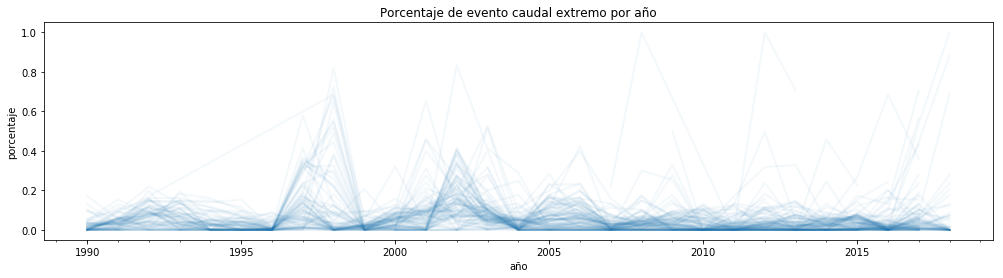

In [24]:
fig, ax=plt.subplots(figsize=(17,4))
data_caudal_ex = data.groupby(['codigo_estacion',pd.Grouper(key='fecha',freq='A')])['caudal_extremo'].mean()
for estacion in data.codigo_estacion.unique():
    data_caudal_ex.loc[estacion].plot(ax=ax,color='tab:blue', alpha=0.05, lw=2)
ax.set_title('Porcentaje de evento caudal extremo por año')
ax.set_ylabel('porcentaje')
ax.set_xlabel('año')
plt.show()

6. Hagan un plot del porcentaje de eventos extremos a través del tiempo (caudal_extremo, temp_extremo, precip_extremo). Se han vuelto más o menos comunes?

Se requiere definir un total, es decir una ventana de tiempo, para obtener un porcentaje sobre eventos totales. Si se toman años, en su agregacion de meses se pierde una posible estacionalidad. Primero se grafican por año, luego por estación del año (x4 datos).

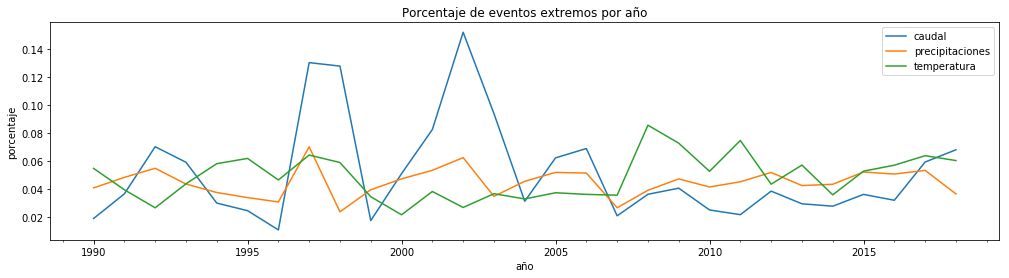

In [25]:
datos_anuales_caudalex = data.groupby(pd.Grouper(key='fecha',freq='A'))[[x+'_extremo' for x in data_cols.keys()]].mean()
fig, ax = plt.subplots(figsize=(17,4))
for col in data_cols.keys():
    datos_anuales_caudalex[col+'_extremo'].plot(ax=ax, label=data_cols[col]['nombre'])

ax.legend()
ax.set_title('Porcentaje de eventos extremos por año')
ax.set_xlabel('año')
ax.set_ylabel('porcentaje')

plt.show()

7. Predicción de caudal extremo. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de un caudal extremo (la variable binaria caudal_extremo). Siéntete libre de generar variables adicionales y/o complementar con variables externas. ¿Qué datos podemos usar y cuáles no? Por supuesto, no podemos usar datos del futuro, pero ¿es lícito usar información del mismo día? ¿del día anterior? Todo depende de cómo propongas que el modelo se puede usar. Haz una propuesta de cómo usar tu modelo en la práctica (por ejemplo: una vez entrenado, voy a tomar los datos de XXX hasta el lunes y predecir para el día siguiente). Dada la propuesta, declara restricciones de información para caudal, temperatura y precipitación


Para la predicción de caudales extremos se deben definir variables y ventana de tiempo.

In [70]:
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np

## Preparación de datos
Usaré los datos de caudal, temperatura y precipitaciones de los 7 días anteriores para realizar la predicción. Para esto generaré algunas variables adicionales para cada una de los datos que tenemos:

- Promedio en los 7 dias anteriores
- Desviación estandar en los 7 días anteriores
- Tendencia en los 7 días anteriores (sacando la pendiente de una regresión lineal)
- Porcentaje de días extremos en los 7 días anteriores

Además, sólo incluiré directamente el dato de caudal, temperatura y precipitaciones del día anterior.

Por último, dado que la variable caudal extremo es relativa a la estacion del año, usaré los percentiles en vez del dato real para mantener la relación entre las variables a través de las estaciones y cuentas. Según nuestra definición, un evento extremo en verano no es lo mismo que un evento extremo en invierno en temperatura pero si en terminos de percentiles, por lo que es mejor usar percentiles que las unidades directas para que el modelo pueda tomar en cuenta eventos en verano e invierno indistintamente. Esto mismo aplica para las diferencias entre las cuencas: lo que es extremo en una no es extremo en otra.

Nota: Inicialmente lo hice con el dato real y no usando los percentiles. Solo cambiar esto mejoró el modelo final un 17% en recall y 4% en precisión. Pueden ver los resultados sin hacer este cambio en la versión anterior del notebook en el repositorio.

Primero calculamos rolling mean con 7 dias, agrupando por cuenca.

In [27]:
rolling_mean = data.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')).rolling(7, min_periods=7)[[x + '_pct' for x in data_cols.keys()]].mean()

rolling_mean.columns = [x + '_rolling_mean' for x in data_cols.keys()]

rolling_mean.reset_index(inplace=True)

rolling_mean.head(20)

,codigo_estacion,fecha,caudal_rolling_mean,precip_promedio_rolling_mean,temp_max_promedio_rolling_mean
0,1020003,1990-01-01,NaN,NaN,NaN
1,1020003,1990-01-02,NaN,NaN,NaN
2,1020003,1990-01-03,NaN,NaN,NaN
3,1020003,1990-01-04,NaN,NaN,NaN
4,1020003,1990-01-05,NaN,NaN,NaN
5,1020003,1990-01-06,NaN,NaN,NaN
6,1020003,1990-01-07,0.312999,0.547844,0.741953
7,1020003,1990-01-08,0.332384,0.557331,0.768906
8,1020003,1990-01-09,0.346217,0.557331,0.786071
9,1020003,1990-01-10,0.346217,0.557331,0.772416


Rolling slope (tendencia) , por cuenca con 7 días. Toma tiempo

In [28]:
rolling_slope = data.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                             .rolling(7, min_periods=7)[[x + '_pct' for x in data_cols.keys()]] \
                                             .apply(lambda x: linregress(range(7), x)[0])

rolling_slope.columns = [x + '_rolling_slope' for x in data_cols.keys()]

rolling_slope.reset_index(inplace=True)

rolling_slope.head(20)

C:\Users\iriqu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


,codigo_estacion,fecha,caudal_rolling_slope,precip_promedio_rolling_slope,temp_max_promedio_rolling_slope
0,1020003,1990-01-01,NaN,NaN,NaN
1,1020003,1990-01-02,NaN,NaN,NaN
2,1020003,1990-01-03,NaN,NaN,NaN
3,1020003,1990-01-04,NaN,NaN,NaN
4,1020003,1990-01-05,NaN,NaN,NaN
5,1020003,1990-01-06,NaN,NaN,NaN
6,1020003,1990-01-07,0.046361,0.118869,-0.011052
7,1020003,1990-01-08,0.040781,0.082516,-0.050544
8,1020003,1990-01-09,0.026191,-0.012923,-0.014466
9,1020003,1990-01-10,0.004655,-0.108362,-0.014384


Rolling std con 7 días agrupado por cuenca

In [29]:
rolling_std = data.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                            .rolling(7, min_periods=7)[[x + '_pct' for x in data_cols.keys()]].std()

rolling_std.columns = [x + '_rolling_std' for x in data_cols.keys()]

rolling_std.reset_index(inplace=True)

rolling_std.head(20)

,codigo_estacion,fecha,caudal_rolling_std,precip_promedio_rolling_std,temp_max_promedio_rolling_std
0,1020003,1990-01-01,NaN,NaN,NaN
1,1020003,1990-01-02,NaN,NaN,NaN
2,1020003,1990-01-03,NaN,NaN,NaN
3,1020003,1990-01-04,NaN,NaN,NaN
4,1020003,1990-01-05,NaN,NaN,NaN
5,1020003,1990-01-06,NaN,NaN,NaN
6,1020003,1990-01-07,0.123504,0.322461,0.190382
7,1020003,1990-01-08,0.119347,0.317431,0.162206
8,1020003,1990-01-09,0.111175,0.317431,0.179139
9,1020003,1990-01-10,0.111175,0.317431,0.179110


Rolling extremo con 7 días, agrupado por cuenca

In [30]:
rolling_extremo = data.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                            .rolling(7, min_periods=7)[[x + '_extremo' for x in data_cols.keys()]].mean()

rolling_extremo.columns = [x + '_rolling_extremo' for x in data_cols.keys()]

rolling_extremo.reset_index(inplace=True)

rolling_extremo.head(20)

,codigo_estacion,fecha,caudal_rolling_extremo,precip_promedio_rolling_extremo,temp_max_promedio_rolling_extremo
0,1020003,1990-01-01,NaN,NaN,NaN
1,1020003,1990-01-02,NaN,NaN,NaN
2,1020003,1990-01-03,NaN,NaN,NaN
3,1020003,1990-01-04,NaN,NaN,NaN
4,1020003,1990-01-05,NaN,NaN,NaN
5,1020003,1990-01-06,NaN,NaN,NaN
6,1020003,1990-01-07,0.0,0.142857,0.142857
7,1020003,1990-01-08,0.0,0.142857,0.142857
8,1020003,1990-01-09,0.0,0.142857,0.285714
9,1020003,1990-01-10,0.0,0.142857,0.285714


Se unen las variables para la modelación

In [31]:
final_df = data[['codigo_estacion', 'fecha', 'caudal_extremo'] + [x + '_pct' for x in data_cols.keys()]]

final_df = final_df.merge(rolling_mean, on=['codigo_estacion', 'fecha'])
final_df = final_df.merge(rolling_std, on=['codigo_estacion', 'fecha'])
final_df = final_df.merge(rolling_slope, on=['codigo_estacion', 'fecha'])
final_df = final_df.merge(rolling_extremo, on=['codigo_estacion', 'fecha'])

final_df.head(20)

,codigo_estacion,fecha,caudal_extremo,caudal_pct,precip_promedio_pct,temp_max_promedio_pct,caudal_rolling_mean,precip_promedio_rolling_mean,temp_max_promedio_rolling_mean,caudal_rolling_std,precip_promedio_rolling_std,temp_max_promedio_rolling_std,caudal_rolling_slope,precip_promedio_rolling_slope,temp_max_promedio_rolling_slope,caudal_rolling_extremo,precip_promedio_rolling_extremo,temp_max_promedio_rolling_extremo
0,1020003,1990-01-01,0,0.232525,0.373972,0.503124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1020003,1990-01-02,0,0.232525,0.175576,0.861724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1020003,1990-01-03,0,0.260074,0.175576,0.827364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1020003,1990-01-04,0,0.201686,0.550164,0.996252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1020003,1990-01-05,0,0.285156,0.857730,0.861724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1020003,1990-01-06,0,0.501439,0.986431,0.541441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1020003,1990-01-07,0,0.477590,0.715461,0.602041,0.312999,0.547844,0.741953,0.123504,0.322461,0.190382,0.046361,0.118869,-0.011052,0.0,0.142857,0.142857
7,1020003,1990-01-08,0,0.368215,0.440378,0.691795,0.332384,0.557331,0.768906,0.119347,0.317431,0.162206,0.040781,0.082516,-0.050544,0.0,0.142857,0.142857
8,1020003,1990-01-09,0,0.329359,0.175576,0.981883,0.346217,0.557331,0.786071,0.111175,0.317431,0.179139,0.026191,-0.012923,-0.014466,0.0,0.142857,0.285714
9,1020003,1990-01-10,0,0.260074,0.175576,0.731778,0.346217,0.557331,0.772416,0.111175,0.317431,0.179110,0.004655,-0.108362,-0.014384,0.0,0.142857,0.285714


Como queremos predecir el caudal extremo del día siguiente, debemos mover la columna caudal_extremo una posición hacia arriba. Cada fila tendria las variables que vamos a usar para predecir y el resultado de caudal_extremo al dia siguiente.

In [32]:
final_df['caudal_extremo'] = final_df['caudal_extremo'].shift(-1)

final_df.head(20)

,codigo_estacion,fecha,caudal_extremo,caudal_pct,precip_promedio_pct,temp_max_promedio_pct,caudal_rolling_mean,precip_promedio_rolling_mean,temp_max_promedio_rolling_mean,caudal_rolling_std,precip_promedio_rolling_std,temp_max_promedio_rolling_std,caudal_rolling_slope,precip_promedio_rolling_slope,temp_max_promedio_rolling_slope,caudal_rolling_extremo,precip_promedio_rolling_extremo,temp_max_promedio_rolling_extremo
0,1020003,1990-01-01,0.0,0.232525,0.373972,0.503124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1020003,1990-01-02,0.0,0.232525,0.175576,0.861724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1020003,1990-01-03,0.0,0.260074,0.175576,0.827364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1020003,1990-01-04,0.0,0.201686,0.550164,0.996252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1020003,1990-01-05,0.0,0.285156,0.857730,0.861724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1020003,1990-01-06,0.0,0.501439,0.986431,0.541441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1020003,1990-01-07,0.0,0.477590,0.715461,0.602041,0.312999,0.547844,0.741953,0.123504,0.322461,0.190382,0.046361,0.118869,-0.011052,0.0,0.142857,0.142857
7,1020003,1990-01-08,0.0,0.368215,0.440378,0.691795,0.332384,0.557331,0.768906,0.119347,0.317431,0.162206,0.040781,0.082516,-0.050544,0.0,0.142857,0.142857
8,1020003,1990-01-09,0.0,0.329359,0.175576,0.981883,0.346217,0.557331,0.786071,0.111175,0.317431,0.179139,0.026191,-0.012923,-0.014466,0.0,0.142857,0.285714
9,1020003,1990-01-10,0.0,0.260074,0.175576,0.731778,0.346217,0.557331,0.772416,0.111175,0.317431,0.179110,0.004655,-0.108362,-0.014384,0.0,0.142857,0.285714


In [45]:
final_df.isnull().sum()

codigo_estacion                          0
fecha                                    0
caudal_extremo                           1
caudal_pct                               0
precip_promedio_pct                   7799
temp_max_promedio_pct                33662
caudal_rolling_mean                      6
precip_promedio_rolling_mean          8962
temp_max_promedio_rolling_mean       45851
caudal_rolling_std                       6
precip_promedio_rolling_std           8962
temp_max_promedio_rolling_std        45851
caudal_rolling_slope                     6
precip_promedio_rolling_slope         8962
temp_max_promedio_rolling_slope      45851
caudal_rolling_extremo                   6
precip_promedio_rolling_extremo          6
temp_max_promedio_rolling_extremo        6
dtype: int64

Es necesario deshacerse de las filas con valores missing

In [46]:
len(final_df)

892222

In [47]:
final_df.dropna(inplace=True)

In [48]:
len(final_df)

843830

### Train/Test split

En vez de hacer un split 80/20 random, buscaré una fecha para hacer el split que separe el 80% de las mediciones antes de esa fecha (para train) y 20% después de esa fecha (para test).

In [53]:
mask = final_df.fecha > '2012'

mask.mean()

0.22654563122903904

In [54]:
y = final_df.caudal_extremo
X = final_df.iloc[:,3:].copy()

In [55]:
y_train = y[~mask].values
X_train = X[~mask].values

y_test = y[mask].values
X_test = X[mask].values

### Escalar las variables
Importante

In [56]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logit

Voy a probar con dos modelos simples (sin tuning de parametros). Primero Logit como benchmark y luego XGBoost.

In [57]:
logit_clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

In [58]:
y_pred_logit = logit_clf.predict_proba(X_test)[:, 1]

In [59]:
metrics.accuracy_score(y_test, y_pred_logit > 0.5)

0.9788351485096722

In [60]:
metrics.roc_auc_score(y_test, y_pred_logit > 0.5)

0.8069007771502344

In [61]:
print(metrics.classification_report(y_test, y_pred_logit > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    184261
         1.0       0.75      0.62      0.68      6905

   micro avg       0.98      0.98      0.98    191166
   macro avg       0.87      0.81      0.83    191166
weighted avg       0.98      0.98      0.98    191166



### XGBoost

In [62]:
xgb_clf = XGBClassifier().fit(X_train, y_train)

In [64]:
y_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]

In [65]:
metrics.accuracy_score(y_test, y_pred_xgb > 0.5)

0.9848822489354802

In [66]:
metrics.roc_auc_score(y_test, y_pred_xgb > 0.5)

0.8730444015162024

In [67]:
print(metrics.classification_report(y_test, y_pred_xgb > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    184261
         1.0       0.81      0.75      0.78      6905

   micro avg       0.98      0.98      0.98    191166
   macro avg       0.90      0.87      0.89    191166
weighted avg       0.98      0.98      0.98    191166



### Análisis del resultado

El modelo XGBoost tiene una mejor performance que el Logit en todas las metricas. Por definición tenemos que sólo el 5% de las observaciones tienen caudal extremo, por lo que usar accuracy para medir performance en este caso no tiene sentido.

Precisión y recall son mejores metricas en este caso. Con el modelo XGBoost estamos capturando un 74% del total de eventos de caudal extremo (recall), con una precisión de 80%. No me parece nada mal para no haber hecho ningun tuning.

Abajo podemos ver las variables más importantes en XGBoost.

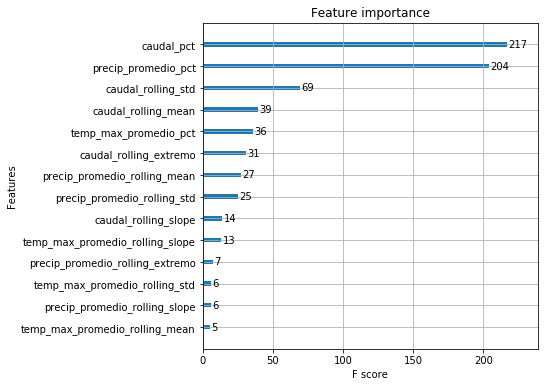

In [68]:
#Por como lo hice antes no muestra los nombres de las variables por defecto
mapper = {'f{0}'.format(i): v for i, v in enumerate(X.columns)}
mapped = {mapper[k]: v for k, v in xgb_clf.get_booster().get_fscore().items()}

fig, ax = plt.subplots(figsize=(6,6))

plot_importance(mapped, ax=ax)

plt.show()

Las variables más importantes son el caudal y precipitaciones del dia anterior (en percentil). Luego vienen las features que creamos de estas mismas dos variables con datos de los ultimos 7 dias usando desviacion estandar y promedio. Y siguiendo esta la temperatura del dia anterior y las veces que hubo caudal extremo en los ultimos 7 dias.

Creo que estos resultados hacen mucho sentido, y las variables mas importantes son las que uno esperaría.

In [71]:
precision_xgb, recall_xgb, threshold_xgb = metrics.precision_recall_curve(y_test, y_pred_xgb)

pos = np.argmin(np.abs(recall_xgb - .7))

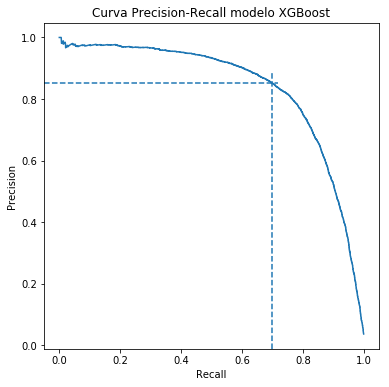

In [72]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_xgb, precision_xgb)

ax.axvline(recall_xgb[pos], ymax=precision_xgb[pos], ls='--')
ax.axhline(precision_xgb[pos], xmax=recall_xgb[pos], ls='--')

ax.set_title('Curva Precision-Recall modelo XGBoost')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [73]:
recall_xgb[pos], precision_xgb[pos]

(0.7000724112961622, 0.8512061982743441)

Si quisieramos capturar el 70% de los eventos de caudales extremos, la precisión del modelo es de 83%.

Esto quiere decir que si usamos este modelo para dar una alerta de aluvión (asumiendo que en realidad hay un aluvión con nuestra definición de caudal extremo) nos equivocaríamos 17% de las veces. Además, otro 30% de las veces que efectivamente hay un aluvión no estaríamos dando un aviso.

Creo que capturar sólo el 70% de los eventos de caudales extremos no es suficiente (en 3 de cada 10 aluviones no habría aviso). Sin embargo, la precisión del modelo es bastante alta para este nivel de captura y los falsos positivos serían pocos. El uso de un modelo de estas características en la vida real dependería de la capacidad de predicción que existe actualmente. (Nuevamente, asumiendo que en realidad hay un aluvión o desborde con nuestra definición de caudal extremo)

8 Análisis de resultado del modelo.

* Qué performance tiene el modelo? Qué métricas usaste para medir esa performance? Cuáles son las variables más importantes? Qué opinión te merecen los resultados?

* Si quisiéramos capturar alrededor de un 70% de los eventos de caudales extremos. Cuál es la precisión de tu modelo con ese porcentaje de captura? Cuéntanos si te parece útil.


Next steps
Tunear hiperparametros de XGBoost, aunque no creo que la ganancia sea tan considerable.
Probar predicción con LSTM.
Investigar uso de un LSTM+autoencoder para hacer feature extraction automático (como muestran aquí)